In [ ]:
import glob
import json
import pickle as pkl
import pandas as pd

from densePhrases.scripts.sampler import QAWikiDumpSampler

### params

In [2]:
opennq_path = 'train_preprocessed.json'
wiki_dev_path = 'dev_wiki'
wiki_full_path = '/data/dph-data/wikidump/20181220_concat'
wiki_cache = 'wiki_cache'

### Process 1/100th of Wikipedia

In [3]:
%%time
sampler_dev = QAWikiDumpSampler(
    path_qa=opennq_path,
    path_wiki=wiki_dev_path,
    path_cache='wiki_cache_dev',
)

reading QA dataset into a dataframe...
QA df has 79168 rows
reading wiki dump into a dataframe...
wiki df has 129730 rows
run `build_index` next before running queries
CPU times: user 1.46 s, sys: 151 ms, total: 1.61 s
Wall time: 1.64 s


In [17]:
%%time
# build index
sampler_dev.build_index()

building BM25 index of the wiki paragraphs
done building the index. you can use the `query` method now.
CPU times: user 28.6 s, sys: 408 ms, total: 29 s
Wall time: 29 s


### Natural Questions data

In [8]:
df_nq = sampler_dev.df_qa
len(df_nq)

79168

In [9]:
df_nq.answer_cnt.sum()

96676

In [10]:
df_nq.sample(n=10, random_state=0)

,id,question,answer_cnt,answers
937,train_937,what side of the road to they drive on in aust...,1,[on the left]
46520,train_46520,who wrote the song when we by tank,3,"[Carl McCormick, Johnnie Newt, Durrell Babbs]"
65747,train_65747,when does the new series of ex on the beach st...,1,[20 March 2018]
17428,train_17428,who played uncle arthur in the comedy company,1,[Glenn Robbins]
32582,train_32582,where do chicken wings and drumettes come from,1,[chicken wing section]
64736,train_64736,where is pepsin most active in the body,1,[stomach]
50023,train_50023,surname of woman who owns pie shop in sweeny todd,1,[Lovett]
54540,train_54540,who is the actress who plays alex on big bang ...,1,[Margo Cathleen Harshman]
16277,train_16277,where is white matter located in spinal cord,1,[superficial parts]
16202,train_16202,who sings the theme song for touched by an angel,1,[Della Reese]


#### Questions can have multiple answers!

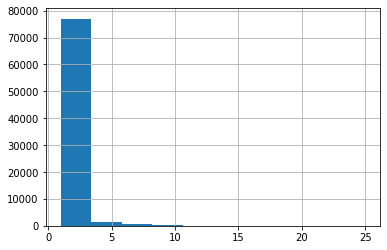

In [11]:
_ = df_nq.answer_cnt.hist()

### wiki dump

In [13]:
df_wiki_dev = sampler_dev.df_wiki
df_wiki_dev.paragraph_cnt.describe()

count    129730.000000
mean         42.838973
std          33.365861
min           1.000000
25%          18.000000
50%          35.000000
75%          58.000000
max         206.000000
Name: paragraph_cnt, dtype: float64

In [15]:
df_wiki_dev.sample(3, random_state=0)

,file,file_idx,article_idx,paragraph_idx,title,paragraph_cnt,paragraph,paragraph_char_cnt
44091,dev_wiki/0002,2,417,23,Dutch language,69,Limburgish has the status of official regiona...,711
1665,dev_wiki/0000,0,84,21,History of construction,47,Vitruvius gives details of many Roman machine...,1052
65279,dev_wiki/0003,3,582,23,Continent,28,Some argue that continents are accretionary c...,649


In [16]:
df_wiki_dev.title.value_counts()

List of Madagascar (franchise) characters    206
Economic history of the United States        195
List of Kung Fu Panda characters             190
Reconstruction Era                           188
Iran–Iraq War                                175
                                            ... 
List of governors of Jammu and Kashmir         1
Dog (zodiac)                                   1
2013 US Open – Women's Singles                 1
List of cities in Andhra Pradesh               1
List of most-followed Instagram accounts       1
Name: title, Length: 7136, dtype: int64

In [18]:
sampler_dev.query('kung fu', top_n=5)

,file,file_idx,article_idx,paragraph_idx,title,paragraph_cnt,paragraph,paragraph_char_cnt
1896,dev_wiki/0000,0,93,59,List of Kung Fu Panda characters,190,Master Sheep is a Kung Fu Master who was amon...,629
1897,dev_wiki/0000,0,93,60,List of Kung Fu Panda characters,190,Master Dolphin is a dolphin who was reference...,550
2003,dev_wiki/0000,0,93,166,List of Kung Fu Panda characters,190,"Sum is a giant panda that appears in ""Kung Fu...",537
22374,dev_wiki/0001,1,166,10,The Karate Kid (2010 film),18,"Despite maintaining the original title, the 2...",612
1891,dev_wiki/0000,0,93,54,List of Kung Fu Panda characters,190,Master Leopard is a Kung Fu Master who is bri...,596


In [21]:
# process 10 questions
res = sampler_dev.process_queries(n=10, n_jobs=-1)
res.paragraph_cnt

1994

In [22]:
res.article_cnt

1137

### Process full Wiki dump

In [ ]:
# this will take about an hour and consume ~50GB of memory
# it's single-threaded :(
# %%time
# sampler = QAWikiDumpSampler(
#     path_qa=opennq_path,
#     path_wiki=wiki_full_path,
#     path_cache='wiki_cache',
#     clear_cache=True,
# )
# sample.build_index()

In [ ]:
# takes ~6 hours on a machine with 64 cores
# peak memory is < 100GB
# matches = sampler.write_wiki_dump(
#     n=7_500,  # processes 7,500 questions
#     cache=True,
#     n_jobs=64,
#     match_pkl_path: str = "wiki_matches.pkl"  # pickle `matches`
#     dump_folder="wiki_dump",  # write to this folder
#     dump_chunk_size=1_000,  # each file is 1,000 articles
# )

In [45]:
!ls -lh wiki_dump | head

total 868M
-rw-r--r-- 1 root root  1.3M May 28 00:23 0
-rw-r--r-- 1 root root  1.3M May 28 00:23 1
-rw-r--r-- 1 root root  1.3M May 28 00:23 10
-rw-r--r-- 1 root root  1.2M May 28 00:24 100
-rw-r--r-- 1 root root  1.3M May 28 00:24 101
-rw-r--r-- 1 root root  1.2M May 28 00:24 102
-rw-r--r-- 1 root root  1.3M May 28 00:24 103
-rw-r--r-- 1 root root  1.2M May 28 00:24 104
-rw-r--r-- 1 root root  1.2M May 28 00:24 105
ls: write error: Broken pipe


### sample file

In [26]:
data0 = json.load(open('wiki_dump/0'))
len(data0['data'])

1000

In [27]:
data0['data'][0]

{'title': 'Ochlodes yuma',
 'paragraphs': [{'context': ' Ochlodes yuma, the Yuma skipper, is a species of grass skipper in the family of butterflies known as Hesperiidae. It is found in North America. The MONA or Hodges number for "Ochlodes yuma" is 4057. These five subspecies belong to the species "Ochlodes yuma":'}]}

In [29]:
data0['data'][2]

{'title': 'Ocho apellidos vascos',
 'paragraphs': [{'context': ' The weekend of its premiere, the film gathered an audience of 404,020 which resulted in box office grossing of 2.72 million euros. On its second weekend its grossing increased by 56%, third best behind "The Impossible" and "Avatar" in its first ten days with a total 4.4 million euros. By April it became the most watched Spanish film in Spain with more than 6.5 million viewers and the second film with the greatest box office grossing in Spain, only behind "Avatar", with a box-office of more than 45 million euros (more than 62 millon dollars). It has grossed in Spain and a total of internationally.'}]}

### number of files

In [34]:
article_cnts = pd.Series(
    len(json.load(open(file))['data'])
    for file in glob.glob('wiki_dump/*')
)

In [47]:
len(article_cnts)

696

In [36]:
article_cnts.describe()

count     696.000000
mean      998.915230
std        28.618201
min       245.000000
25%      1000.000000
50%      1000.000000
75%      1000.000000
max      1000.000000
dtype: float64

In [35]:
paragraph_cnts = pd.Series(
    len(article['paragraphs'])
    for file in glob.glob('wiki_dump/*')
    for article in json.load(open(file))['data']
)

In [43]:
assert len(paragraph_cnts) == 695245

In [40]:
paragraph_cnts.describe()

count    695245.000000
mean          1.580833
std           1.757483
min           1.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         140.000000
dtype: float64

In [48]:
assert paragraph_cnts.sum() == 1_099_066

## Some learnings
- `rank_bm25` is very memory hungry and single-threaded
- found a BM25 implementation built on top of sklearn's `TfidfVectorizer`. Still single-threaded but is not densely stored so it had 1/5 of the `rank_bm25` memory footprint for the full Wiki index.
- sharing the index with `joblib`'s `sharedmem` to run parallel queries. Also querying using the sklearn version is ~ 10x faster.
- `pyserini` has a pre-built [`enwiki-paragraphs`](https://github.com/castorini/pyserini/blob/master/docs/prebuilt-indexes.md) index. It's 15GB to download and has very little memory footprint. Queries run in less than a second. But I couldn't figure out how to map the retrieved indices back to the DPH Wiki dumps so abandoned this.

In [50]:
!tar -czf wiki7500.tar.gz wiki_cache

In [51]:
!ls -lh wiki7500.tar.gz

-rw-r--r-- 1 root root 599M May 28 04:36 wiki7500.tar.gz
